<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Juan Aranda
- Nombre de alumno 2: Nicolás Crocco


\### **Link de repositorio de GitHub:** `https://github.com/Juanaranda/Aranda_Crocco`

# Importamos librerias útiles

In [1]:
!pip install -qq xgboost optuna eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00


### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.compose import make_column_transformer
import eli5
from eli5.sklearn import PermutationImportance

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

path = '/content/drive/MyDrive/Laboratorios/Lab_10'
path1 = '/content/drive/MyDrive/12vo Semestre/Laboratorio de Programación Científica/Laboratorios/Lab_10'

#df = pd.read_csv(path+'/diabetes_data.csv')
df = pd.read_csv(path1+'/diabetes_data.csv')

df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [ ]:
# EDA
print('Tipos de las columnas del dataset:')
print(df.dtypes)
print('-------------------')
print('Valores únicos por columna del dataset:')
print(df.nunique())
print('-------------------')

Tipos de las columnas del dataset:
Age                     float64
Sex                     float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Stroke                  float64
HighBP                  float64
Diabetes                float64
dtype: object
-------------------
Valores únicos por columna del dataset:
Age                     13
Sex                      2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
GenHlth           

## 2. Clasificación de pacientes con diabetes (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo haga una buena elección de las features?.

In [5]:
!pip install xgboost eli5

In [6]:
#Separar los datos en características (X) y la variable objetivo (y)
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Obtener los nombres de las columnas antes del preprocesamiento
column_names = X.columns.tolist()

# Definir el preprocesamiento para características numéricas manteniendo los nombres de las columnas
numeric_features = X.select_dtypes(include=['float64']).columns.tolist()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


# Combinar preprocesamiento manteniendo los nombres de las columnas
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])


# Definir el modelo con nombres de características
model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

# Entrenar el modelo
model_xgb.fit(X_train, y_train)

#Mae
y_pred_xgb = model_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"MAE con XGBRegressor: {mae_xgb}")

MAE con XGBRegressor: 0.2511493033453568


In [7]:
from sklearn.metrics import classification_report, roc_auc_score

# Mostrar métricas de evaluación
print(classification_report(y_test, y_pred_xgb))

y_pred_xgb_prob = model_xgb.predict_proba(X_test)[:, 1]

# Calcular y mostrar el AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_xgb_prob)
print(f'AUC-ROC: {auc_roc}')

              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.79      0.76      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139

AUC-ROC: 0.825139538043288


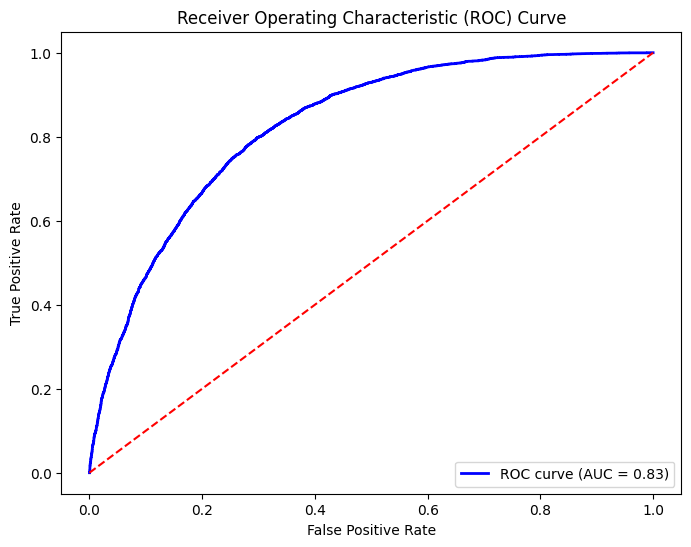

In [8]:
#Curva roc
# Calcular la tasa de verdaderos positivos (TPR), tasa de falsos positivos (FPR) y umbral
# Calcular la probabilidad de la clase positiva
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_prob)

# Calcular el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

En primer lugar, en el pipeline se usó StandardScaler para la estandarización de los datos, lo que puede ser muy beneficioso en el contexto de clasificar pacientes con diabetes, debido a que de esta manera se asegura que las características con diferentes escalas (como niveles de glucosa, presión arterial, índice de masa corporal, etc.) tengan un impacto equitativo en la predicción de la diabetes. Esto puede ayudar al modelo a aprender patrones más significativos y mejorar su capacidad predictiva.


**¿El modelo es un buen predictor de diabetes?**

De acuerdo a las métricas obtenidas, el modelo parece tener un rendimiento decente, con una precisión (accuracy) del 75%. Esto significa que el 75% de las predicciones hechas por el modelo son correctas.

Además se obtuvo un MAE (Error Absoluto Medio) de 0.25, lo que indica que, en promedio, las predicciones del modelo se desvían en 0.25 unidades de la medida de la variable objetivo.

Ahora, al evaluar las métricas específicas para la predicción de la clase positiva y negativa, se revelan patrones diferentes: para la clase positiva, el modelo mostró un desempeño decente con valores de 0.73, 0.79 y 0.76 en precisión, recall y f1-score, respectivamente. Estos valores sugieren que el modelo logra capturar el 73% de los verdaderos casos positivos, identificando correctamente el 79% de ellos y alcanzando un equilibrio entre precisión y exhaustividad con un puntaje de 0.76.

Para la clase negativa, las métricas indican un rendimiento similar con valores de 0.77, 0.71 y 0.74 en precisión, recall y f1-score, respectivamente. Esto significa que el modelo logra una precisión del 77% al predecir casos negativos, aunque su capacidad para capturar todos los casos negativos (recall) es del 71%, con un f1-score promedio de 0.74.


El AUC-ROC (Área bajo la curva ROC) es de 0.825, lo que indica que el modelo tiene una buena capacidad para distinguir entre las clases positivas y negativas.



**Las métricas utilizadas buscan explicar lo siguiente:**

El MAE (Error Absoluto Medio) es una medida de la magnitud promedio de los errores en las predicciones del modelo. En este caso, el valor de MAE indica que, en promedio, las predicciones del modelo tienen un error absoluto de aproximadamente 0.25 en la escala de la variable objetivo. Un valor bajo de MAE sugiere que el modelo tiene un buen rendimiento en términos de precisión de las predicciones.

La precisión (accuracy) es una métrica general que muestra qué tan bien el modelo clasifica correctamente todas las clases.

La precisión, recall y f1-score se calculan para cada clase por separado (clase 0 y clase 1 en este caso). Precision es la proporción de verdaderos positivos sobre todos los positivos predichos. Recall es la proporción de verdaderos positivos sobre todos los positivos reales.

F1-score es una medida que combina precisión y recall.

El AUC-ROC es una medida que evalúa la capacidad de un modelo para discriminar entre clases, independientemente de la distribución de clases o el umbral de clasificación.

**¿Las métricas utilizadas para medir la predictibilidad permiten asegurar que el modelo haga una buena elección de las features?**

Si bien estas métricas son útiles para evaluar el rendimiento general del modelo, no proporcionan directamente información sobre si el modelo selecciona correctamente las características relevantes.
Para comprender si el modelo hace una buena elección de características, sería necesario utilizar métodos de interpretación, como la importancia de características, y validar si las características más importantes coinciden con el conocimiento experto o la comprensión clínica de la diabetes.

La importancia de características, el análisis de contribución y otras técnicas de interpretación pueden brindar más claridad sobre la relación entre las características y la predicción del modelo.


## 3. Importancia de las features con XGBoost (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

f0 = Age
f1 = Sex
f2 = HighChol
f3 = CholCheck
f4 = BMI
f5 = Smoker
f6 = HeartDiseaseorAttack
f7 = PhysActivity
f8 = Fruits
f9 = Veggies
f10 = HvyAlcoholConsump
f11 = GenHlth
f12 = MentHlth
f13 = PhysHlth
f14 = DiffWalk
f15 = Stroke
f16 = HighBP


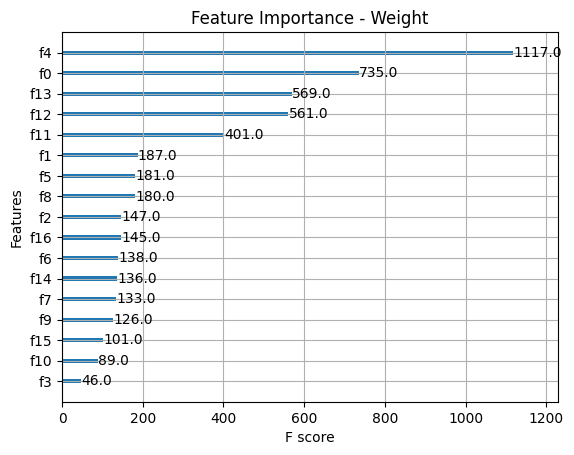

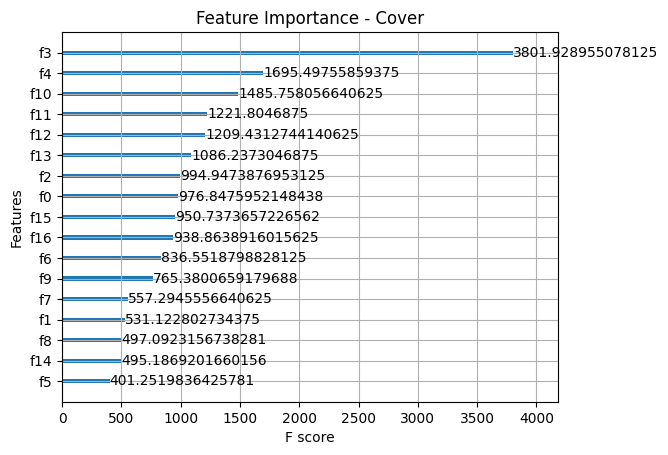

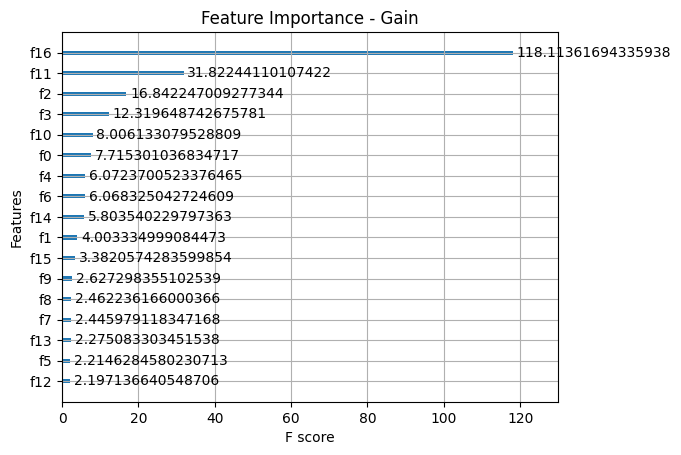

In [9]:
for idx, feature_name in enumerate(column_names):
    print(f"f{idx} = {feature_name}")
# Obtener la importancia de las características utilizando diferentes métodos
plot_importance(model_xgb.named_steps['classifier'], importance_type='weight')
plt.title('Feature Importance - Weight')
plt.show()

plot_importance(model_xgb.named_steps['classifier'], importance_type='cover')
plt.title('Feature Importance - Cover')
plt.show()

plot_importance(model_xgb.named_steps['classifier'], importance_type='gain')
plt.title('Feature Importance - Gain')
plt.show()

De acuerdo a los gráficos se puede notar que las variables más importantes difieren de acuerdo al método que se aplique. En el caso del weight la feature con mayor importancia es 'BMI', en cuanto al método cover la más importante es 'CholCheck', mientras que para el método Gain, la variable con mayor importancia es 'HighBP'.

Es común ver que los resultados pueden diferir entre estos métodos. Por ejemplo, una característica con alta ganancia (gain) puede no tener una alta frecuencia de aparición (weight), y viceversa. Estas diferencias surgen debido a las diferentes perspectivas que cada métrica considera al evaluar la importancia de una característica.

Aunque estos métodos ofrecen una visión general de la importancia de las características, presentan una limitación importante: no capturan las relaciones complejas entre características. Además, la importancia relativa calculada puede variar entre los métodos y puede no reflejar completamente la interpretabilidad de un modelo basado en árboles, especialmente si las características están altamente correlacionadas.



## 4. Métodos Agnósticos Globales (1.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [10]:
# Calcular la importancia de las características usando el método de permutación
perm = PermutationImportance(model_xgb.named_steps['classifier'], random_state=42)
perm.fit(model_xgb.named_steps['preprocessor'].transform(X_test), y_test)

# Visualizar los resultados del método de permutación
eli5.show_weights(perm, feature_names=column_names)

Weight,Feature
0.0604 ± 0.0039,GenHlth
0.0332 ± 0.0019,BMI
0.0258 ± 0.0039,Age
0.0144 ± 0.0023,HighBP
0.0112 ± 0.0020,HighChol
0.0044 ± 0.0014,HeartDiseaseorAttack
0.0039 ± 0.0012,HvyAlcoholConsump
0.0036 ± 0.0013,DiffWalk
0.0036 ± 0.0009,CholCheck
0.0031 ± 0.0017,Sex


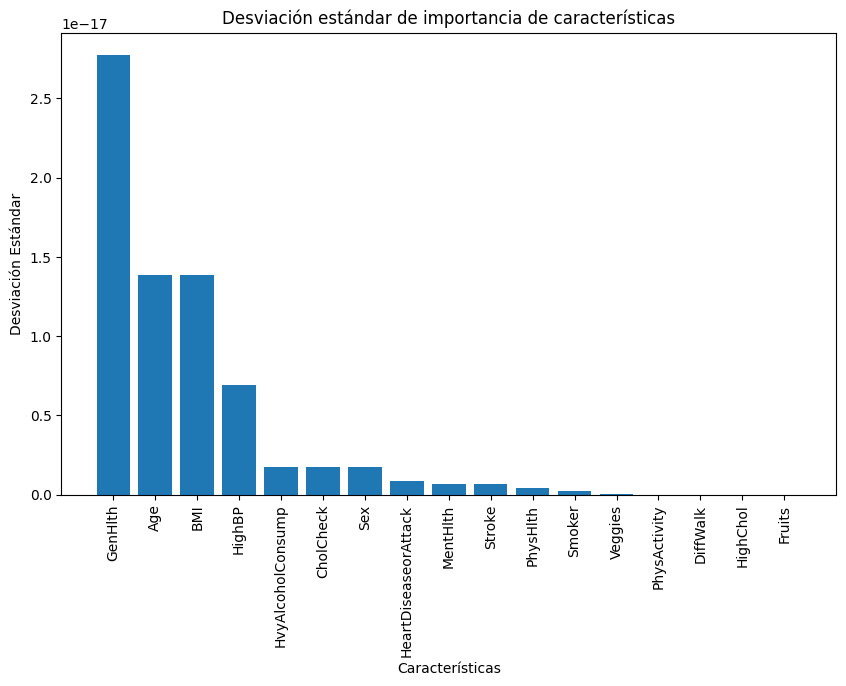

In [11]:
# Obtener los nombres de las columnas
column_names = X.columns

# Repetir el proceso 30 veces
results = []
for _ in range(30):
    perm = PermutationImportance(model_xgb.named_steps['classifier'], random_state=42)
    perm.fit(model_xgb.named_steps['preprocessor'].transform(X_test), y_test)
    results.append(perm.feature_importances_)

# Calcular la desviación estándar de los resultados
std_dev = np.std(results, axis=0)

# Obtener el índice ordenado de la desviación estándar
sorted_index = np.argsort(std_dev)[::-1]

# Ordenar los nombres de las columnas y la desviación estándar según el índice
sorted_column_names = column_names[sorted_index]
sorted_std_dev = std_dev[sorted_index]

# Visualización de la desviación estándar ordenada
plt.figure(figsize=(10, 6))
plt.bar(sorted_column_names, sorted_std_dev)
plt.title('Desviación estándar de importancia de características')
plt.xlabel('Características')
plt.ylabel('Desviación Estándar')
plt.xticks(rotation=90)
plt.show()


In [12]:
# Calcular la desviación estándar de los resultados
std_dev = np.std(results, axis=0)
print(f"Desviación estándar de los resultados: {std_dev}")

Desviación estándar de los resultados: [1.38777878e-17 1.73472348e-18 0.00000000e+00 1.73472348e-18
 1.38777878e-17 2.16840434e-19 8.67361738e-19 0.00000000e+00
 0.00000000e+00 5.42101086e-20 1.73472348e-18 2.77555756e-17
 6.50521303e-19 4.33680869e-19 0.00000000e+00 6.50521303e-19
 6.93889390e-18]


**¿Cómo mide la importancia de las features su propuesta?**

El método de permutación evalúa la importancia de las características al medir el impacto en el rendimiento del modelo al permutar aleatoriamente los valores de una característica mientras se mantienen los demás datos constantes. La diferencia en el rendimiento del modelo antes y después de la permutación proporciona una medida de la importancia de esa característica: si al permutar una característica el rendimiento del modelo disminuye significativamente, se considera una característica importante.

**¿Qué features tienen un mayor impacto en la salida del modelo? Comente las 5 primeras, ¿Tienen sentido?**

Las características con mayor impacto en la predicción del modelo, según los resultados del método de permutación, son:

GenHlth: La salud general parece ser la característica más influyente en la predicción, con un impacto sustancial en el rendimiento del modelo.

BMI: El índice de masa corporal también muestra una influencia significativa en las predicciones.

Age: La edad se posiciona como una característica importante, lo cual es común en modelos de enfermedades crónicas.

HighBP: La presión arterial alta también aparece como una característica relevante.

HvyAlcoholConsump: Los niveles altos consumo de alcohol muestran un impacto en la predicción del modelo.

Estas características tienen sentido desde el punto de vista médico, ya que factores como la salud general, el índice de masa corporal, la edad y los problemas de salud relacionados con la presión arterial suelen estar asociados con la diabetes. Además, es lógico pensar que el alto consumo de alcohol aumente los riesgos de padecer diabetes, debido al alto contenido de azúcar que las bebidas alcoólicas conienten.

**¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?**

En comparación con las importancias de características anteriores, este método proporciona una perspectiva más detallada y específica sobre el impacto individual de cada característica en el modelo. Además, al repetir el proceso y observar la desviación estándar, se nota que hay características con desviaciones muy bajas, indicando una alta consistencia en su importancia a lo largo de las repeticiones.

**Ventajas y desventajas del método implementado:**

**Ventajas:**

Robustez: La repetición del método permite evaluar la consistencia en la importancia de las características.

Evaluación individual: Proporciona una comprensión detallada del impacto de cada característica en la predicción del modelo.

Independcia del modelo: Es aplicable a una gran variedad de modelos de aprendizaje automático.

**Desventajas:**

Computacionalmente costoso: Si el conjunto de datos es grande o el modelo es complejo, realizar múltiples permutaciones puede requerir mucho tiempo de cómputo.

Dependiente de la representación de datos: Las características altamente correlacionadas pueden afectar la evaluación de la importancia de características.

Interpretación subjetiva: La interpretación de la importancia de las características puede depender del contexto del problema o del conocimiento experto.

## 5. Métodos Agnósticos Locales (2.0 puntos)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### 5.1 Calculando Shap Values (0.4 puntos)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [13]:
!pip install shap pdpbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.7 MB/s eta 0:00:00


In [14]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

[02:34:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[02:34:18] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


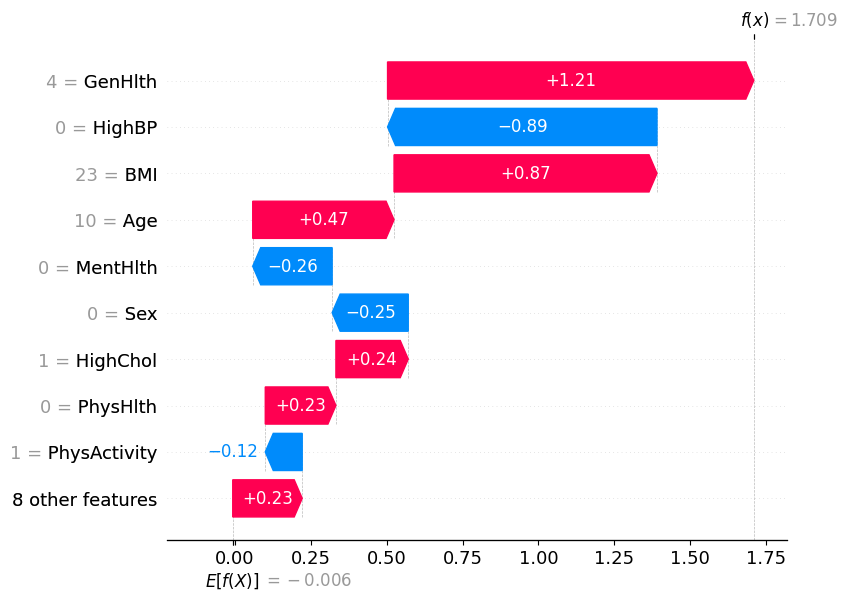

In [15]:
import shap

# Calculamos los shap values
explainer = shap.Explainer(model_xgb.named_steps['classifier'])
shap_values = explainer(X_test)

# Plot de los shap values
shap.plots.waterfall(shap_values[0])

**¿Qué representa cada número en su resultado?**<br>
Cada valor SHAP representa la contribución de una característica específica a la diferencia entre la predicción del modelo y la predicción promedio del conjunto de datos.

**¿Es posible atribuir un significado a la positividad/negatividad de cada valor?**<br>
Sí, es posible. Los valores positivos indican una contribución que impulsa la predicción hacia arriba (hacia la clase positiva), mientras que los valores negativos indican una contribución que lleva la predicción hacia abajo (hacia la clase negativa).


### 5.2 Aporte local (0.4 puntos)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

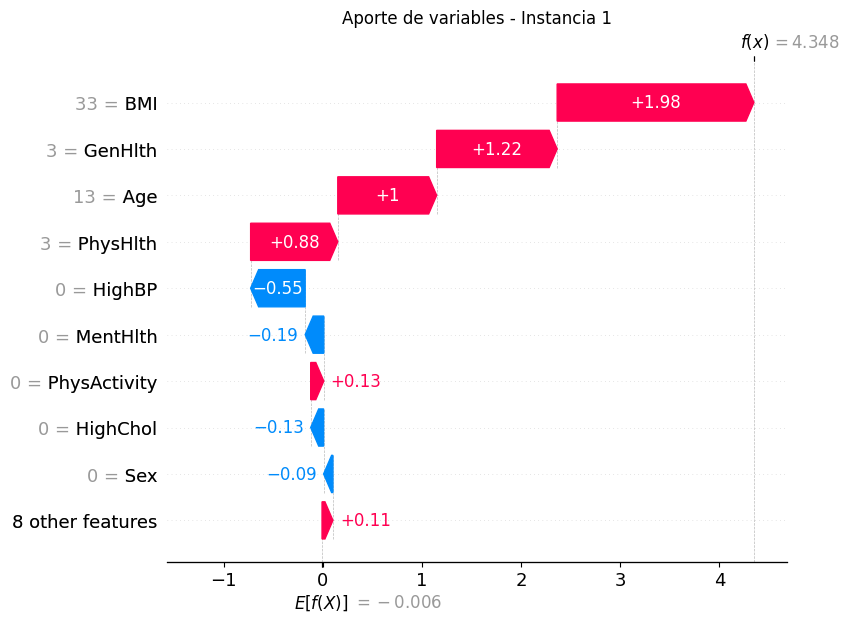

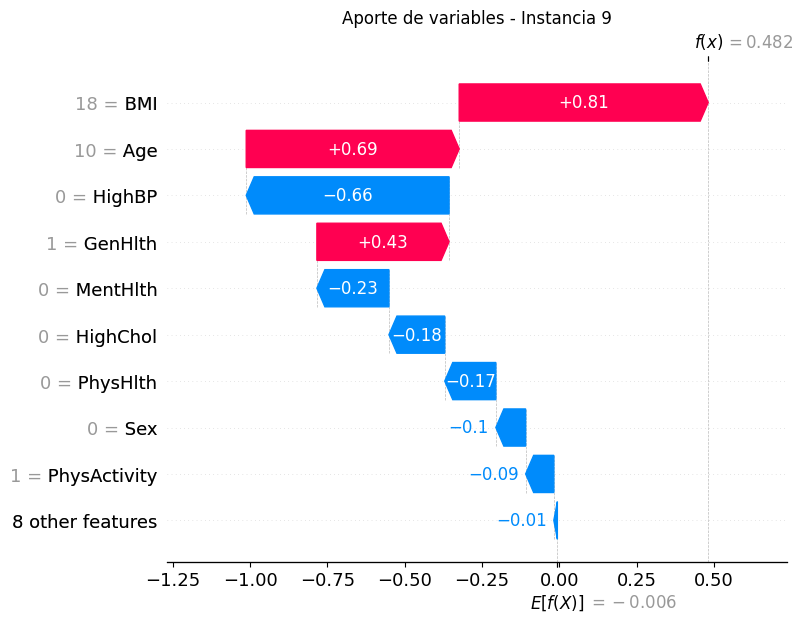

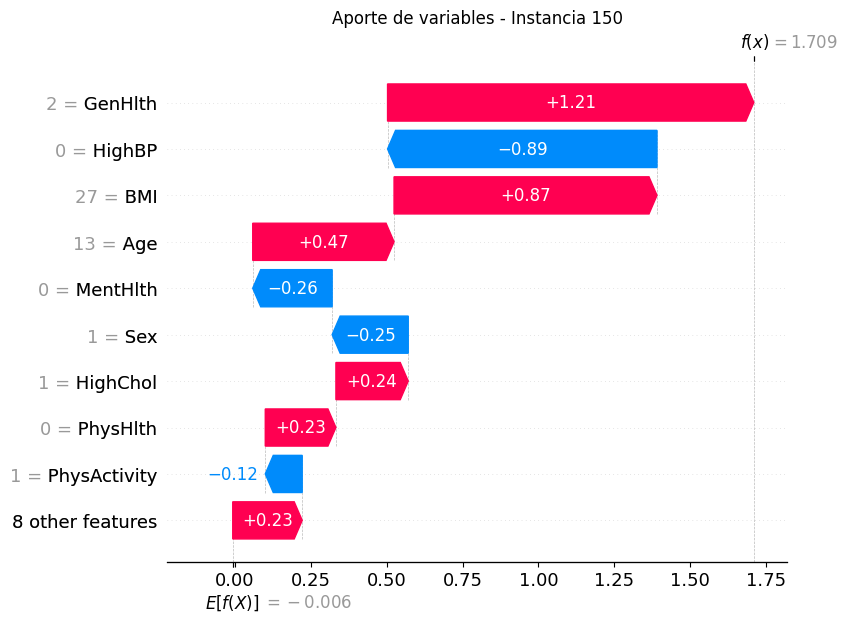

In [ ]:
instancias = [0,8,149]
for i in instancias:
  # Crear un objeto Explanation
  shap_exp = shap.Explanation(values=shap_values[i+1], base_values=explainer.expected_value, feature_names=column_names)

  # Visualizar los SHAP values para la primera instancia de datos de prueba
  print('')
  plt.title(f"Aporte de variables - Instancia {i+1}")
  shap.plots.waterfall(shap_exp)


Se realizaron 3 observaciones, la primera con 1 instancia, la segunda con 9 y la tercera con 150.<br>

Para la primera observación se puede notar una influencia positiva de tres de las cuatro variables más relevante que vimos anteirormente: BMI, GenHlth y Age. Además, PhysHlth y PhysActivity influyen también de forma positiva, mientras el resto de las variables con más de un 0,09 aporte, influyen de forma negativa.

En la segunda observación se puede ver que BMI, Age y GenHlth mantienen su inlfuencia positiva, pero a su vez disminuyendo su aporte. Se puede apreciar que todas las otras variables muestran una influencia negativa, siendo HighBP y MentHlth las con un mayor aporte.

Finalmente, en la observación con 150 instancias, lo primero que se puede notar es que se idéntintica a la observación en que se interpretaron las predicciones del modelo entrenado. En este, se puede ver un aporte positivo importante de las variables GenHlth, BMI y Age. Con menor aporte, las variables HighCol y PhysHlth también influyen de forma positiva, junto con el aporte de las 8 features restantes. Por otro lado, la varibale HighBP afecta fuertemente y de manera negativa, y las variables

De lo anterior se puede deducir que:

Las variables más destacadas (BMI, Age, GenHlth) parecen tener un impacto positivo en todas las observaciones, lo que sugiere una posible generalización de su efecto en el dataset completo.

Para otras variables con efectos cambiantes, como HighBP, HighCol, PhysHlth y PhysActivity, la generalización podría ser menos clara debido a sus efectos variables en las diferentes observaciones.

Sin embargo, aunque estas observaciones ofrecen una idea de las tendencias generales, es crucial considerar la variabilidad y la complejidad del dataset completo antes de generalizar completamente estos resultados. La relación entre las variables y la probabilidad de tener diabetes puede verse afectada por la presencia de otras características, interacciones no lineales o factores adicionales que pueden cambiar los efectos de las variables en el modelo global.







### 5.3 Aporte global (0.4 puntos)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

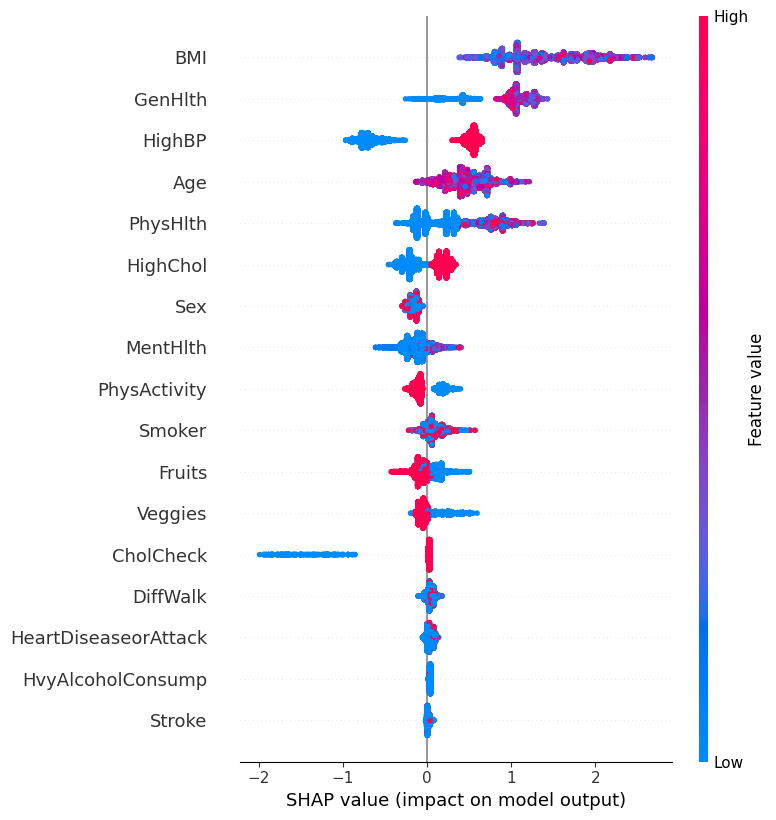

In [ ]:
# Generar un gráfico de resumen global
shap.summary_plot(shap_values, X_test, feature_names=column_names)

A nivel global se ve que el BMI tiene un impacto positivo tanto a niveles "bajos" como "altos" de la variable. La variable GenHlth tiene un impacto mayor a medida que el valor crece. La variable HighBP tiene un claro impacto ya que un paciente catalogado con presion alta tiene un impacto positivo claro en contraste con alguien que no, lo mismo sucede con la variable HighChol pero en menor medida aunque, En cuanto a Cholcheck sucede algo llamativo, un bajo valor tiene un impacto negativo, pero un alto valor practicaente no impacta en el modelo. En el caso de PhysActivity, Fruits y Veggies sucede lo contrario, un valor más alto tiene un impacto negativo. La variable Sex tiene un impacto negativo en general pero en una medida muy leve, mientras que con la variable Age ocurre algo similar pero con impacto positivo. En cuanto a la variable Smoker, esta parece tener un impacto más positivo, aunque en algunos casos muestra un impacto negativo independiente de un valor bajo o alto. Mientras que con MentHlth sucede lo contrario. En relación a las demás variables, estas no parecen tener un efecto claro en la probabilidad de clasificar a un paciente como diabético.

### 5.4 Scatter plot (0.4 puntos)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

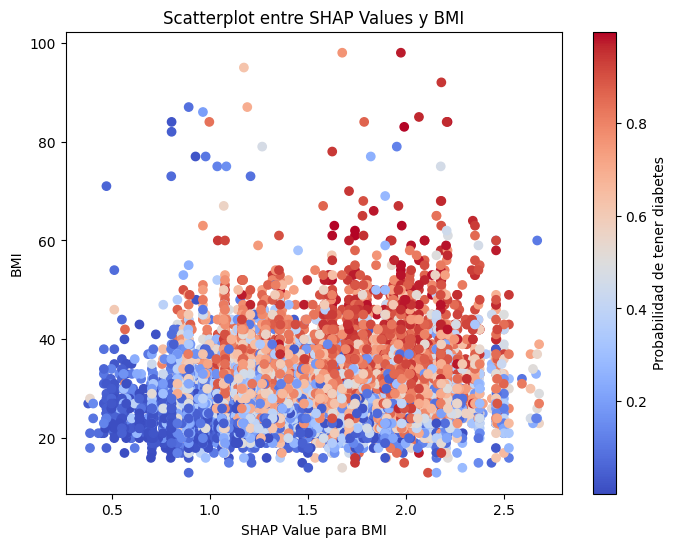

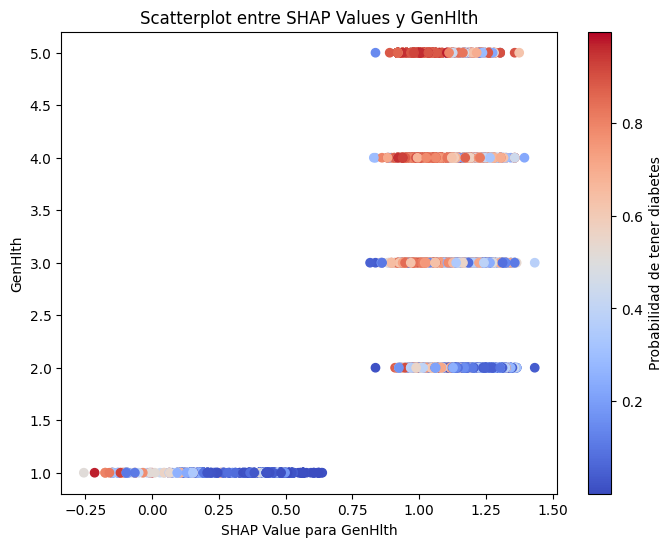

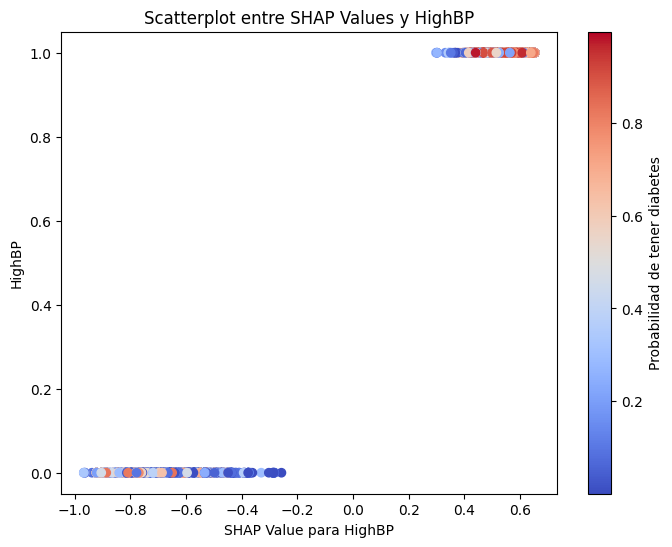

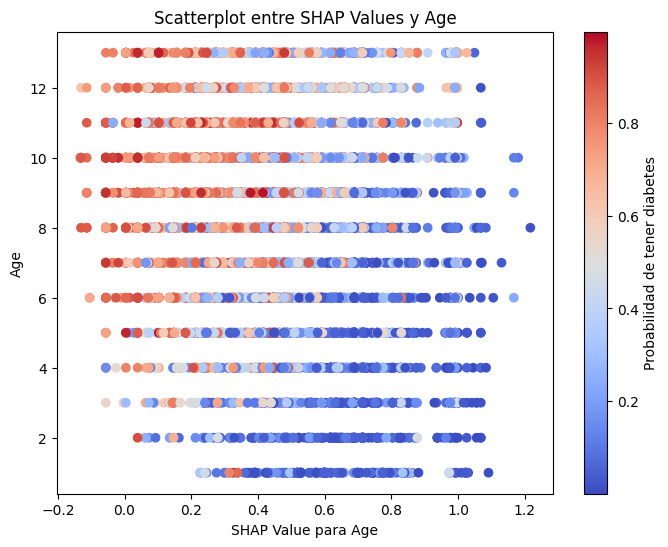

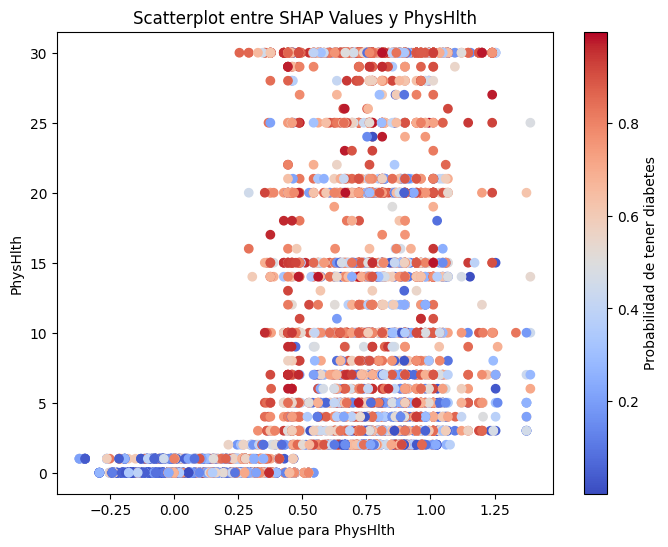

In [16]:
# Obtener los valores de los SHAP values de la explicación
shap_values_array = shap_values.values

# Calcular el valor absoluto promedio de los SHAP values para cada feature
mean_absolute_shap = pd.DataFrame(np.abs(shap_values_array)).mean(axis=0)

# Crear un DataFrame con los SHAP values y los índices numéricos como nombres de columnas
shap_df = pd.DataFrame(shap_values_array, columns=range(shap_values_array.shape[1]))

# Obtener las 5 características con mayor impacto global
top_features = mean_absolute_shap.nlargest(5).index.tolist()

# Crear scatterplots para las primeras 5 características con mayor impacto global
for feature in top_features:
    shap_feature = shap_df[feature].values
    feature_values = X_test.iloc[:, feature].values

    plt.figure(figsize=(8, 6))
    plt.scatter(shap_feature, feature_values, c=y_pred_xgb_prob, cmap='coolwarm')
    plt.colorbar(label='Probabilidad de tener diabetes')

    # Obtener el nombre de la característica usando el índice
    feature_name = column_names[feature]

    plt.xlabel(f'SHAP Value para {feature_name}')
    plt.ylabel(f'{feature_name}')
    plt.title(f'Scatterplot entre SHAP Values y {feature_name}')
    plt.show()


Al inspeccionar los gráficos para cada característica, se puede notar que la mayoría presentan correlaciones con los valores SHAP, lo que indica que estas características son predictivas para el diagnóstico de diabetes.<br>
Además, se puede observar que los resultados concuerdan con lo obtenido anteriormente al analizar los niveles de shap value globales para cada atributo.<br>
En cuanto a los resultados en general, se puede decir que son razonables. Existe una tendencia, no del todo clara, a aumentar las probabilidades de tener diabetes a mayores niveles de BMI (Índice de Masa Corporal). Para HighBP (presión arterial alta ) y con la variable GenHlth (salud en general) en cambio, existe una clara tendencia de aumento de probabilidad con el valor shap. Para esta última variable, se puede suponer que a un mayor valor peor es la condición de salud de la persona, si no se cumple esto, ya no podría decirse que los resultados para esta son razonables. Una tendencia similar a GenHlth se ve en PhysHlth (salud física), por lo que la suposición anterior pareciera ser correcta. Finalmente, en cuanto a la variable age, se puede observar una leve correlación de la diabetes con el aumento de la edad.

### 5.5 Partial Dependence Plot (0.4 puntos)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

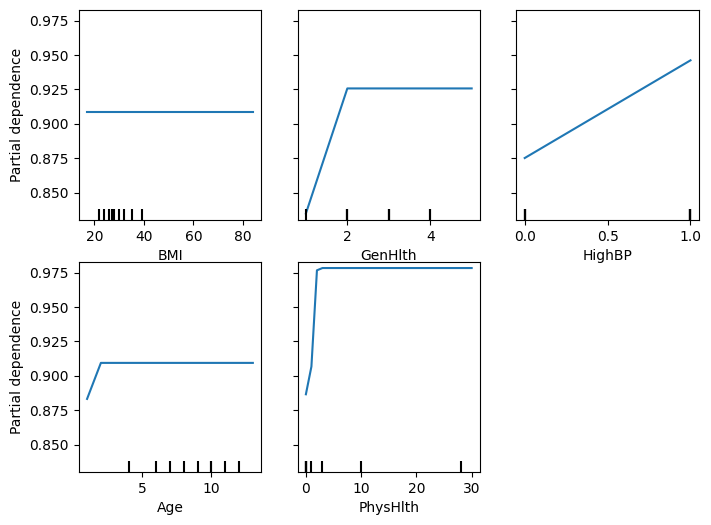

In [17]:
from sklearn.inspection import PartialDependenceDisplay

# Definir una submuestra de 1000 observaciones
sample = X_test.sample(1000)

fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(model_xgb.named_steps['classifier'], sample, top_features, ax=ax)

plt.show()

Se puede observar que BMI tiene una curva plana, por lo que esta característica tiene poco efecto en la salida del modelo. El resto de las variables poseen una pendiente positiva, algunas más marcadas que otras, pero esto indica que, en alguna medida, hay una relación positiva entre dichos features y la salida del modelo.<br>
Por otro lado, es probable que estas conclusiones no sean generalizables a todo el conjunto de dato. Esto debido a que los PDPs exhiben el efecto promedio de una característica en la salida del modelo, pero este efecto puede variar entre diferentes observaciones. Especialmente cuando existen interacciones entre los features, el impacto de uno puede depender del valor de otros. Por ende, aunque los PDPs pueden ofrecer información valiosa sobre cómo una característica afecta, en promedio, la salida del modelo, no siempre logran capturar la totalidad de esta relación.

## 6. Sistema de Reglas! (1.0 puntos)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [18]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.4 MB/s eta 0:00:00


In [19]:
from alibi.explainers import AnchorTabular

In [20]:
predict_fn = lambda x: model_xgb.predict(pd.DataFrame(x, columns=X_test.columns))

explainer = AnchorTabular(predict_fn, feature_names=list(X_test.columns))

explainer.fit(X_test.values)

idx = 1000
# explicar predicción idx 1000
explanation = explainer.explain(X_test.values[idx], threshold=0.95)
print('Observation:', idx)
print('Prediction:', explanation.anchor)
print('Precision:', explanation.precision)
print('Coverage:', explanation.coverage,'\n')

idx = 3001
# explicar predicción idx 3001
explanation = explainer.explain(X_test.values[idx], threshold=0.95)
print('Observation:', idx)
print('Prediction:', explanation.anchor)
print('Precision:', explanation.precision)
print('Coverage:', explanation.coverage,'\n')

idx = 5751
# explicar predicción idx 5751
explanation = explainer.explain(X_test.values[idx], threshold=0.95)
print('Observation:', idx)
print('Prediction:', explanation.anchor)
print('Precision:', explanation.precision)
print('Coverage:', explanation.coverage,'\n')

Observation: 1000
Prediction: ['HeartDiseaseorAttack > 0.00', 'HighBP > 0.00', 'BMI > 25.00', 'Age > 11.00']
Precision: 0.9714285714285714
Coverage: 0.0248 

Observation: 3001
Prediction: ['BMI > 33.00', 'HighBP > 0.00', 'GenHlth > 2.00']
Precision: 0.9704697986577181
Coverage: 0.1375 

Observation: 5751
Prediction: ['GenHlth <= 2.00', 'HighBP <= 0.00', 'BMI <= 25.00']
Precision: 0.9911347517730497
Coverage: 0.1172 



Las reglas propuestas para las observaciones 1000, 3001 y 5751 parecen tener sentido y ofrecen una explicación comprensible de las predicciones del modelo. Estas reglas se centran en características relevantes, como la presión arterial alta (HighBP), el índice de masa corporal (BMI), la edad y la salud general (GenHlth).

En términos de precisión, las reglas demuestran un alto nivel de confiabilidad en la toma de decisiones, con valores que oscilan entre 97.05% y 99.11%. Esto indica que las reglas son efectivas para predecir correctamente las condiciones de salud en las observaciones analizadas.

En cuanto a la cobertura, se observa que las reglas abarcan diferentes proporciones de la población, oscilando entre 2.48% y 13.75%. Estas coberturas indicarían que las reglas son explicaciones locales y no necesariamente se aplican a todo el conjunto de datos. Es decir, aunque estas reglas tienen una alta precisión, su cobertura relativamente baja sugiere que sólo se aplican a una pequeña fracción de todas las observaciones, limitando su generalización.

Estas reglas de decisión proporcionan una valiosa comprensión de cómo el modelo desarrollado toma decisiones para estas observaciones específicas. Su utilidad radica en ofrecer insights claros sobre las variables clave que influyen en las decisiones del modelo, lo que puede ser valioso tanto para el Dr. Simi como para los clientes en la comprensión de las predicciones y la toma de decisiones relacionadas con la salud.

# Retrospectiva... (1.0 puntos)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

En este contexto, los métodos de interpretación local como los valores SHAP o Anchors son los mejores, porque son muy útiles cuando se necesita comprender la decisión específica del modelo para una observación en particular. En un contexto médico, esta interpretación localizada puede ser de gran utilidad, ya que con frecuencia es necesario explicar una decisión o predicción a un paciente o médico.

Los métodos agnósticos locales serían más útiles para el problema del Dr. Simi si el objetivo es brindar explicaciones personalizadas a los clientes sobre las predicciones de su modelo. Esto se debe a que estas técnicas pueden proporcionar reglas claras y específicas sobre cómo se tomó la decisión del modelo para una observación individual, lo que puede ayudar a los clientes an entender y confiar en las predicciones del modelo.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>